<a href="https://colab.research.google.com/github/fredriklilja/stats/blob/main/monte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter

from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import uniform
from scipy.optimize import minimize

import requests
import json

import xarray as xr

In [ ]:
query_params = {
  "query": [
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "BE0101A¤"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2024"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

headers = {"Content-Type": "application/json"}

response = requests.post('https://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101I/LivslangdEttariga', json=query_params, headers=headers)

print(response)

<Response [200]>


In [ ]:
keys = []
values = []

for row in response.json()['data']:
  #print(np.array(row['key']).astype(int), np.array(row['values']).astype(float))
  keys.append(np.array(row['key']).astype(int))
  values.append(np.array(row['values']).astype(float))

keys = np.vstack(keys)
values = np.vstack(values)

scb_arr = np.hstack([keys, values])


In [ ]:
gender, gender_vals = np.unique(scb_arr[:, 0], return_inverse=True)
age, age_vals = np.unique(scb_arr[:, 1], return_inverse=True)

scb_pivot = np.zeros((len(gender), len(age)))

scb_pivot[gender_vals, age_vals] = scb_arr[:, -1]

death_haz = xr.DataArray(scb_pivot, dims=['gender', 'age'], coords={'gender': ['male', 'female'], 'age':range(111)}) / 1000

In [ ]:
death_haz.sel(gender='male', age=slice(90, 110))

<xarray.DataArray (age: 21)> Size: 168B
array([0.15694, 0.17682, 0.19574, 0.21397, 0.2428 , 0.26083, 0.2854 ,
       0.31152, 0.33917, 0.36831, 0.39886, 0.43074, 0.46384, 0.49802,
       0.53313, 0.56896, 0.60529, 0.64185, 0.67835, 0.71445, 0.74977])
Coordinates:
    gender   <U6 24B 'male'
  * age      (age) int64 168B 90 91 92 93 94 95 96 ... 105 106 107 108 109 110

In [ ]:
age = 90
alive = True

while alive:
  death_p = death_haz.sel(gender='male', age=age)
  alive = np.random.choice([True, False], p=[1-death_p, death_p])
  age +=1

print(age)

92


In [ ]:
# Build a function to estimate the parameters of a gamma distribution knowing median and iqr
obs_iqr = 7.9 - 0.8
obs_median = 4.3

def gamma_loss(params):
  alpha, theta = params

  if alpha <= 0 or theta <= 0:
        return np.inf  # Invalid parameters

  q25 = gamma.ppf(0.25, a=alpha, scale=theta)
  q50 = gamma.ppf(0.50, a=alpha, scale=theta)
  q75 = gamma.ppf(0.75, a=alpha, scale=theta)

  iqr = q75 - q25

  loss_val = (iqr - obs_iqr) ** 2 + (q50 - obs_median) ** 2
  return loss_val

result = minimize(gamma_loss, [2, 4], method='Nelder-Mead')

result.x






array([0.94128165, 6.75637619])

The 1-year incidence of probable rupture by initial AAA diameter was 9.4% for AAA of 5.5 to 5.9 cm, 10.2% for AAA of 6.0 to 6.9 cm (19.1% for the subgroup of 6.5-6.9 cm), and 32.5% for AAA of 7.0 cm or more

In [ ]:
def get_rupture_risk(diameter):
  if diameter < 5.5:
    return 0 # It is not zero, check what it is ESVS AAA guidelines???
  if  5.5 <= diameter < 6.0:
    return 0.094
  if  6.0 <= diameter < 7.0:
    return 0.102
  if diameter >= 7.0:
    return 0.325


get_rupture_risk(6)

0.102

In [ ]:
class Patient:
  def __init__(self, age, gender, death_hazard, diameter=55.0):
    self.age = age
    self.alive = True
    self.gender = gender
    self.cohort = None
    self.death_hazard = death_hazard
    self.next_crossroad = iAAA_repair

    self.diam = diameter
    self.aaa = 'intact'


  def choose(self):
    if self.next_crossroad:
      self.next_crossroad(self)
    else:
      return 'SLUT'

In [ ]:
def iAAA_repair(pat: Patient):
  # choose to repair electively or not
  # in this ase 50/50 chance

  p_repair = 0.5
  repair = np.random.choice([True, False], p=[p_repair, 1-p_repair])

  if repair:
    pat.aaa = 'elective repair'
    pat.diam = np.nan
    pat.next_crossroad = post_iAAA_repair
    pat.cohort = 'rep'
  else:
    pat.next_crossroad = get_older
    pat.cohort = 'no rep'

def post_iAAA_repair(pat: Patient):

  if pat.age >= 90:
    p_death = beta(16, 308).rvs()
  else:
    p_death = beta(123, 11140).rvs()

  p_death = 0.05 # Check Carlotas paper for distribution
  death = np.random.choice([True, False], p=[p_death, 1-p_death])

  if death:
    pat.alive = False
    pat.aaa = 'dead elective repair'
    pat.next_crossroad = None
  else:
    pat.next_crossroad = get_older_fixed

def get_older_fixed(pat: Patient):
  p = death_haz.sel(gender=pat.gender, age=pat.age).to_numpy()
  death = np.random.choice([True, False], p=[p, 1-p])

  if death:
    pat.alive = False
    pat.next_crossroad = None
  else:
    pat.age += 1
    pat.next_crossroad = get_older_fixed

def rupture(pat: Patient):

    if pat.diam < 55:
      p_rupture = 0 # It is not zero, check what it is ESVS AAA guidelines???
    if  55 <= pat.diam < 60:
      p_rupture = 0.094
    if  60 <= pat.diam < 70:
      p_rupture =  0.102
    if pat.diam >= 70:
      p_rupture = 0.325

    if pat.aaa == 'repaired':
      p_rupture = 0

    rAAA = np.random.choice([True, False], p=[p_rupture, 1-p_rupture])

    if rAAA:
      #pat.alive = False
      pat.next_crossroad = post_rupture
      pat.aaa = 'rupture'
    else:
      pat.next_crossroad = get_older

def post_rupture(pat: Patient):
  # Decide if dead or alive and with treated AAA after a rupture
  # Values are drawn from a beta-distribution with parameterns frpm Laine et al BJS
  p_death = beta(450, 700).rvs()
  death = np.random.choice([True, False], p=[p_death, 1-p_death])

  if death:
    pat.alive = False
    pat.next_crossroad = None
    pat.aaa = 'rupture'
  else:
    pat.next_crossroad = get_older_fixed
    pat.aaa = 'acute repair'


def get_older(pat: Patient):
  p = death_haz.sel(gender=pat.gender, age=pat.age).to_numpy()

  death = np.random.choice([True, False], p=[p, 1-p])
  if death:
    pat.alive = False
    pat.next_crossroad = None
  else:
    pat.age += 1
    pat.diam += gamma(a=0.94, scale=6.76).rvs()
    pat.next_crossroad = rupture








In [ ]:
uniform(70, 100).rvs()

np.float64(73.27191872211739)

In [ ]:
frames = []
for _ in range(10000):
  age_op = np.random.randint(70, 101)
  nisse = Patient(age_op, 'male', death_haz)

  while nisse.alive:

    nisse.choose()
  frames.append(pd.DataFrame([[age_op, nisse.cohort, nisse.age, nisse.diam, nisse.aaa]], columns=['age_op', 'cohort', 'age_death', 'aaa_diam', 'aaa_status']))

df = pd.concat(frames).reset_index()


In [ ]:
df['FU_years'] = df['age_death'] - df['age_op']

In [ ]:
df.loc[df['cohort'] == 'rep', 'aaa_status'].value_counts()

,count
aaa_status,
elective repair,4736
dead elective repair,252


In [ ]:
df.loc[df['cohort'] == 'no rep', 'aaa_status'].value_counts()

,count
aaa_status,
intact,2067
acute repair,1789
rupture,1156


In [ ]:
df.groupby('cohort')['FU_years'].mean()

,FU_years
cohort,
no rep,5.193136
rep,6.513432


(array([ 968.,  959.,  972.,  958.,  989.,  948.,  936.,  960.,  981.,
        1329.]),
 array([ 70.,  73.,  76.,  79.,  82.,  85.,  88.,  91.,  94.,  97., 100.]),
 <BarContainer object of 10 artists>)

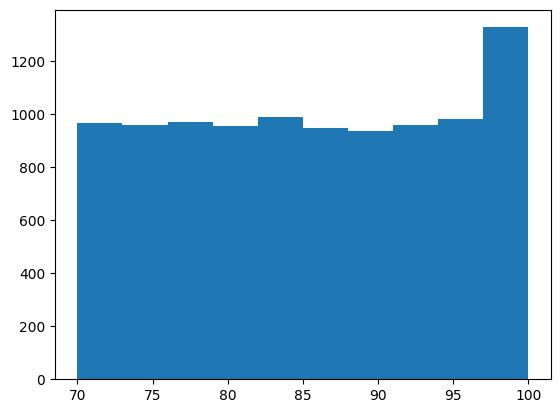

In [ ]:
plt.hist(df['age_op'])

<Axes: xlabel='timeline'>

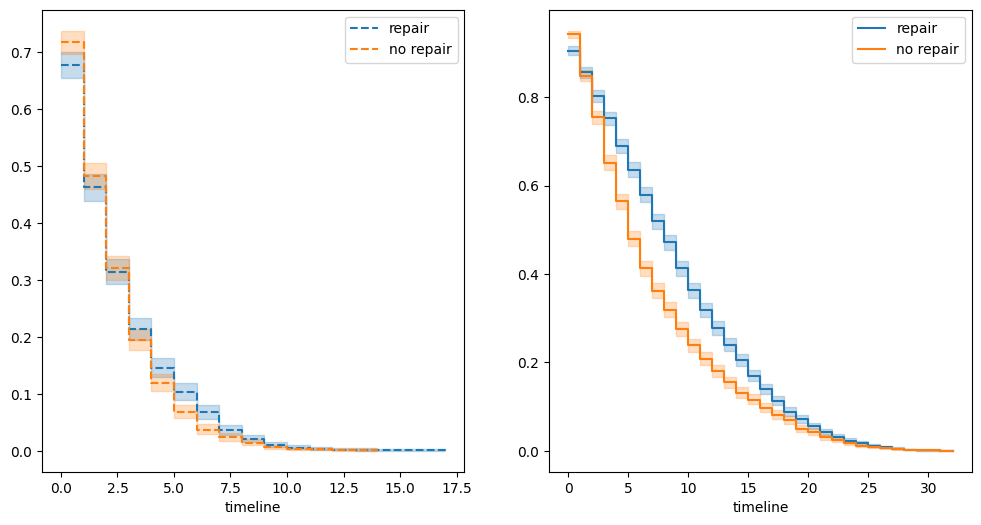

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

kmf = KaplanMeierFitter()

t = df.loc[(df['cohort'] == 'rep') & (df['age_op'] >= 90), 'FU_years']
event = np.ones(len(t))
kmf.fit(t, event)
kmf.plot(label="repair", color='C0', style='--', ax=axs[0])

t = df.loc[(df['cohort'] == 'no rep') & (df['age_op'] >= 90), 'FU_years']
event = np.ones(len(t))
kmf.fit(t, event)
kmf.plot(label="no repair", color='C1', style='--', ax=axs[0])

t = df.loc[(df['cohort'] == 'rep') & (df['age_op'] < 90), 'FU_years']
event = np.ones(len(t))
kmf.fit(t, event)
kmf.plot(label="repair", color='C0', style='-', ax=axs[1])

t = df.loc[(df['cohort'] == 'no rep') & (df['age_op'] < 90), 'FU_years']
event = np.ones(len(t))
kmf.fit(t, event)
kmf.plot(label="no repair", color='C1', style='-', ax=axs[1])

In [ ]:
kmf = KaplanMeierFitter()

arrs_na = []
arrs_nna = []

surv_trt_na =[]
surv_cnl_na =[]
surv_trt_nna =[]
surv_cnl_nna =[]

for _ in range(100):

  # Resample the dataframe in order to obtain CI
  data = df.sample(10000, replace=True)

  # Estimate survival function for NA who did repair
  t = data.loc[(data['cohort'] == 'rep') & (data['age_op'] >= 90), 'FU_years']
  event = np.ones(len(t))
  kmf.fit(t, event)
  surv_prob_trt_na = kmf.cumulative_density_at_times(np.arange(16), label=None).to_numpy()

  # Estimate survival function for NA who did NOT repair
  t = data.loc[(data['cohort'] == 'no rep') & (data['age_op'] >= 90), 'FU_years']
  event = np.ones(len(t))
  kmf.fit(t, event)
  surv_prob_cnl_na = kmf.cumulative_density_at_times(np.arange(16), label=None).to_numpy()

  # Estimate survival function for NNA who did repair
  t = data.loc[(data['cohort'] == 'rep') & (data['age_op'] < 90), 'FU_years']
  event = np.ones(len(t))
  kmf.fit(t, event)
  surv_prob_trt_nna = kmf.cumulative_density_at_times(np.arange(16), label=None).to_numpy()

  # Estimate survival function for NNA who did NOT repair
  t = data.loc[(data['cohort'] == 'no rep') & (data['age_op'] < 90), 'FU_years']
  event = np.ones(len(t))
  kmf.fit(t, event)
  surv_prob_cnl_nna = kmf.cumulative_density_at_times(np.arange(16), label=None).to_numpy()


  arr_na = surv_prob_cnl_na - surv_prob_trt_na
  arr_nna = surv_prob_cnl_nna - surv_prob_trt_nna


  arrs_na.append(arr_na)
  arrs_nna.append(arr_nna)

  surv_trt_na.append(surv_prob_trt_na)
  surv_cnl_na.append(surv_prob_cnl_na)
  surv_trt_nna.append(surv_prob_trt_nna)
  surv_cnl_nna.append(surv_prob_cnl_nna)


arrs_nna = np.vstack(arrs_nna)
arrs_na = np.vstack(arrs_na)

surv_trt_na = np.vstack(surv_trt_na)
surv_cnl_na = np.vstack(surv_cnl_na)
surv_trt_nna = np.vstack(surv_trt_nna)
surv_cnl_nna = np.vstack(surv_cnl_nna)

In [ ]:
print(f'NNT non-nonagenarians at 5 years: {(1 / arrs_nna[:, 6].mean()).round(2)}, 94% CrI: {np.percentile(1 / arrs_nna[:, 6], 3).round(2)} - {np.percentile(1 / arrs_nna[:, 6], 97).round(2)}')
print(f'NNT nonagenarians at 5 years: {(1 / arrs_na[:, 6].mean()).round(2)}, 94% CrI: {np.percentile(1 / arrs_na[:, 6], 3).round(2)} - {np.percentile(1 / arrs_na[:, 6], 97).round(2)}')

NNT non-nonagenarians at 5 years: 5.99, 94% CrI: 5.26 - 6.92
NNT nonagenarians at 5 years: 31.8, 94% CrI: 22.15 - 64.86


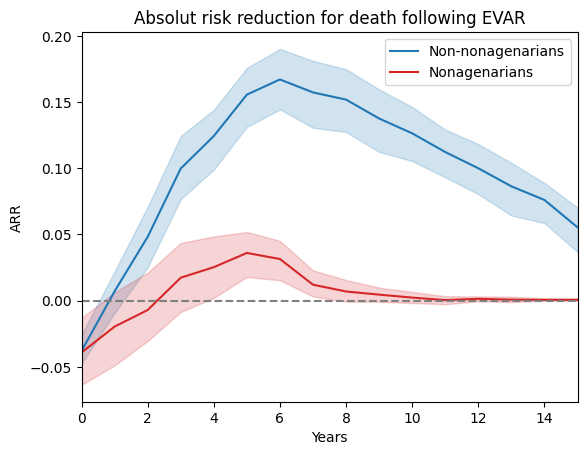

In [ ]:
fig, ax = plt.subplots(1, 1)


ax.plot(arrs_nna.mean(axis=0), color='C0', linestyle='-', label='Non-nonagenarians')
#ax.plot(np.percentile(arrs_nna, 3, axis=0), color='C0')
#ax.plot(np.percentile(arrs_nna, 97, axis=0), color='C0')

ax.fill_between(np.arange(arrs_nna.shape[1]), np.percentile(arrs_nna, 3, axis=0), np.percentile(arrs_nna, 97, axis=0), color='C0', alpha=0.2)

ax.plot(arrs_na.mean(axis=0), color='C3', linestyle='-', label='Nonagenarians')
#ax.plot(np.percentile(arrs_na, 3, axis=0), color='C3')
#ax.plot(np.percentile(arrs_na, 97, axis=0), color='C3')

ax.fill_between(np.arange(arrs_na.shape[1]), np.percentile(arrs_na, 3, axis=0), np.percentile(arrs_na, 97, axis=0), color='C3', alpha=0.2)

ax.hlines(0, 0, 15, color='gray', linestyle='--')

ax.set_xlim(0, 15)
ax.set_title('Absolut risk reduction for death following EVAR')
ax.set_xlabel('Years')
ax.set_ylabel('ARR')

ax.legend()

plt.show()

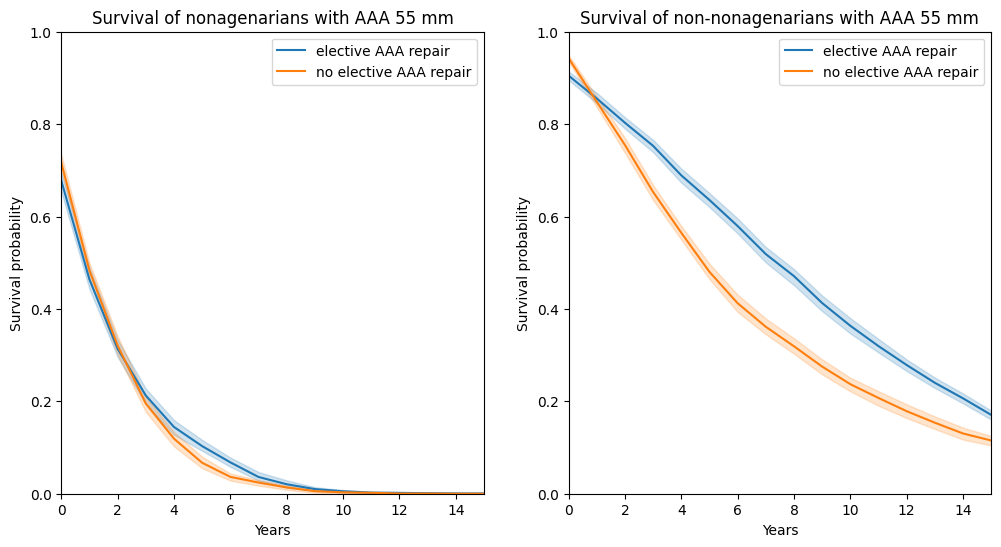

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(1 - surv_trt_na.mean(axis=0), label='elective AAA repair')
ax[0].fill_between(np.arange(surv_trt_na.shape[1]), (1 - np.percentile(surv_trt_na, 3, axis=0)), (1 - np.percentile(surv_trt_na, 97, axis=0)), color='C0', alpha=0.2)

ax[0].plot(1 - surv_cnl_na.mean(axis=0), label='no elective AAA repair')
ax[0].fill_between(np.arange(surv_cnl_na.shape[1]), (1 - np.percentile(surv_cnl_na, 3, axis=0)), (1 - np.percentile(surv_cnl_na, 97, axis=0)), color='C1', alpha=0.2)

ax[1].plot(1 - surv_trt_nna.mean(axis=0), label='elective AAA repair')
ax[1].fill_between(np.arange(surv_trt_na.shape[1]), (1 - np.percentile(surv_trt_nna, 3, axis=0)), (1 - np.percentile(surv_trt_nna, 97, axis=0)), color='C0', alpha=0.2)

ax[1].plot(1 - surv_cnl_nna.mean(axis=0), label='no elective AAA repair')
ax[1].fill_between(np.arange(surv_cnl_nna.shape[1]), (1 - np.percentile(surv_cnl_nna, 3, axis=0)), (1 - np.percentile(surv_cnl_nna, 97, axis=0)), color='C1', alpha=0.2)

ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)

ax[0].set_xlim(0, 15)
ax[1].set_xlim(0, 15)

ax[0].set_title('Survival of nonagenarians with AAA 55 mm')
ax[1].set_title('Survival of non-nonagenarians with AAA 55 mm')

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('Years')
ax[1].set_xlabel('Years')

ax[0].set_ylabel('Survival probability')
ax[1].set_ylabel('Survival probability')

plt.show()

(array([  2.,   5.,  44., 137., 242., 274., 179.,  85.,  24.,   8.]),
 array([-0.00712912, -0.00529671, -0.0034643 , -0.0016319 ,  0.00020051,
         0.00203292,  0.00386532,  0.00569773,  0.00753014,  0.00936254,
         0.01119495]),
 <BarContainer object of 10 artists>)

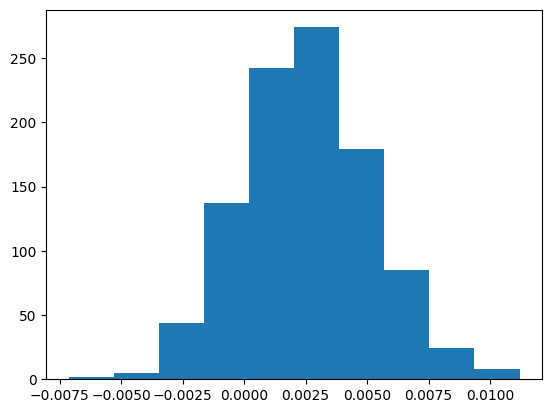

In [ ]:
plt.hist(np.vstack(arrs)[:, 9])